In [1]:
import sys
sys.path.insert(0, '/home/knoop/local/vibes')

import importlib as il

import numpy as np

from matplotlib import pyplot as plt

from vibes.trajectory import reader
from vibes.konstanten import omega_to_THz

HA = il.import_module('vibes.harmonic_analysis')

In [2]:
traj = reader('no_drift.yaml')

.. no_drift.yaml parsed in 3.453s


In [3]:
def _index_offset(atoms, prim, atol=1e-3, rtol=0.0):
    index, offset = [], []
    for pos in atoms.positions:
        spos = np.linalg.solve(prim.cell.T, pos)
        for i, spos2 in enumerate(prim.get_scaled_positions()):
            off = spos - spos2
            off_round = np.round(off)
            if not np.allclose(off, off_round, atol=atol, rtol=rtol):
                continue
            index.append(i)
            off = off_round.astype(int)
            assert np.allclose(off, off_round)
            offset.append(off)
            break
        else:
            raise ValueError('prim not compatible with atoms')

    index, offset = np.array(index), np.array(offset)
    return index, offset

In [4]:
def compute_sed(traj, ideal, prim, k_points, eigenvectors=None):
    """ Computes spectral energy density for a trajectory.

    Parameters
    ----------
    traj : list
        trajectory with atoms objects with velocities
    ideal : ASE atoms object
        ideal atoms object
    prim : ASE atoms object
        compatible primitive cell. Must be aligned correctly
    k_points : list
        list of k points in cart coord (2pi must be included)
    eigenvectors : list
        list of eigenvectors for mode projection
    """
    
    n_branches = 3 * len(prim)

    velocities = []
    for atom in traj:
        velocities.append(atom.get_velocities())
    velocities = np.array(velocities)
    velocities = velocities.transpose(1, 2, 0).copy()
    velocities = np.fft.fft(velocities, axis=2)

    masses = prim.get_masses()
    indices, offsets = _index_offset(ideal, prim)
    
    if eigenvectors is None:
        uvec = np.ones([n_branches, n_branches])
        uvec /= np.linalg.norm(uvec)
        eigenvectors = [uvec for _ in k_points]
    eigenvectors = np.array(eigenvectors)

    pos = np.dot(k_points, np.dot(offsets, prim.cell).T)
    # pos = np.dot(k_points, ideal.positions.T)

    exppos = np.exp(1.0j * pos)
    density = np.zeros((len(k_points), n_branches, velocities.shape[2]))
    for alpha in range(3):
        for b in range(len(masses)):
            for s in range(n_branches):
                tmp = np.zeros([len(k_points), velocities.shape[2]], dtype=np.complex)
                for i in range(len(indices)):
                    index = indices[i]
                    if index != b:
                        continue
                    # sum similar atoms with the same phase
                    e_q = eigenvectors[:, index*3 + alpha, s]
                    tmp += e_q[:, None] * np.outer(exppos[:, i], velocities[i, alpha])

                density[:, s, :] += masses[b] * np.abs(tmp)**2

    return density

In [5]:
fcs, lps = HA.parse_tdep_forceconstant('outfile.forceconstant')

Parse force constants from
  outfile.forceconstant
.. remap representation for supercell:  False
.. Number of atoms:   2
.. Real space cutoff: 3.660 \AA
.. Number of lattice points: 54 (33 unique)
.. time elapsed: 0.002s


In [6]:
il.reload(HA)
ha = HA.HarmonicAnalysis(traj.primitive, traj.supercell, fcs, lps)

Set up harmonic analysis for MgO:
.. found 32 (31) lattice points in 0.011s
.. matched 64 positions in supercell and primitive cell in 0.056s
.. found 32 (31) lattice points in 0.001s
.. time elapsed: 0.229s


In [7]:
seq = compute_sed(traj[:], traj.supercell, traj.primitive, ha.q_points * 2 * np.pi, 
                  eigenvectors=ha.eigenvectors)

In [8]:
tmax = traj[-1].info['nsteps'] * traj[-1].info['dt_fs']

In [9]:
xs = np.arange(len(traj)) / tmax * 1000

.. number of q points reduced from 32 to 8 in 0.178s
q 0
[-1.64723663e-07 -1.64723663e-07  2.32954439e-07  1.35154996e+01
  1.35154996e+01  1.35154996e+01]


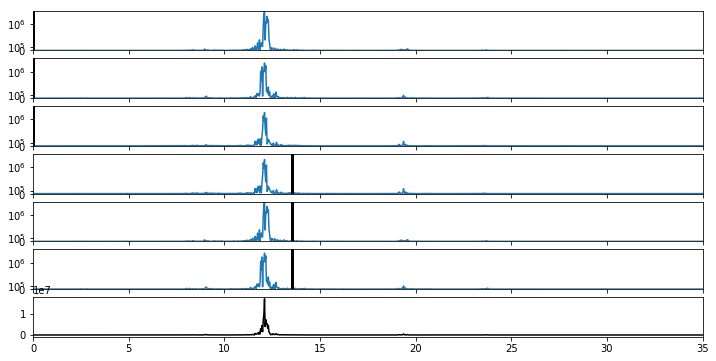

q 1
[ 6.37682208  6.37682208  9.78033009 13.40857304 13.40857304 15.21829601]


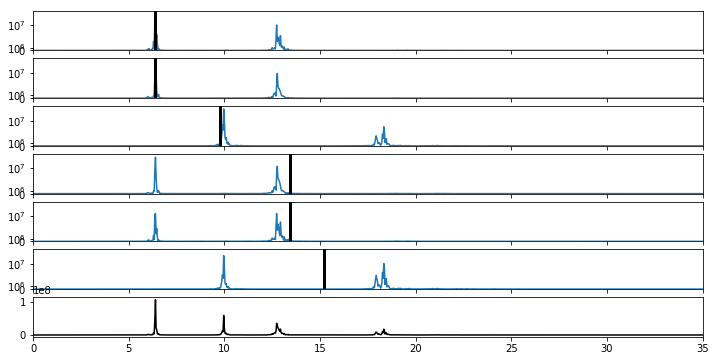

q 2
[ 6.37682208  6.37682208  9.78033009 13.40857304 13.40857304 15.21829601]


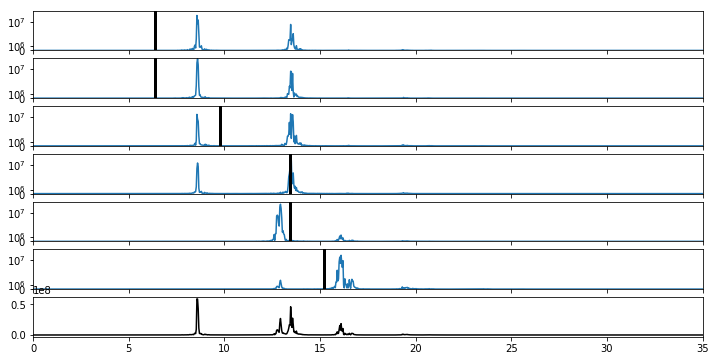

q 3
[ 6.37682208  6.37682208  9.78033009 13.40857304 13.40857304 15.21829601]


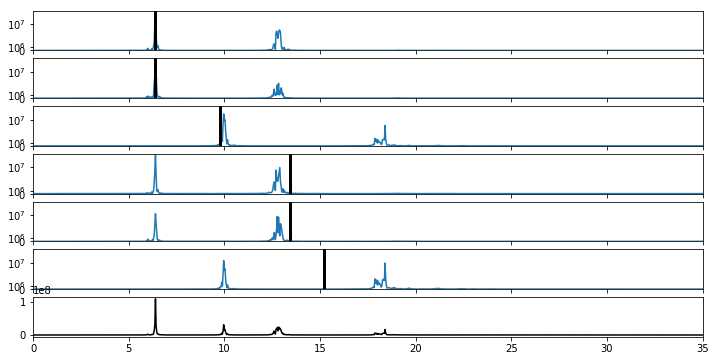

q 4
[ 7.71727407  9.99681142 10.70117137 12.01776273 13.88556023 16.33989088]


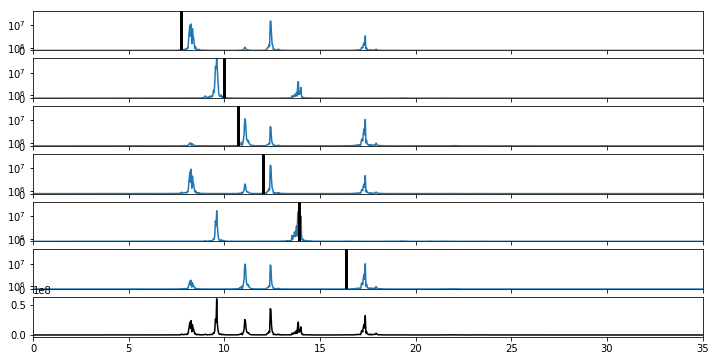

q 5
[ 7.71727407  9.99681142 10.70117137 12.01776273 13.88556023 16.33989088]


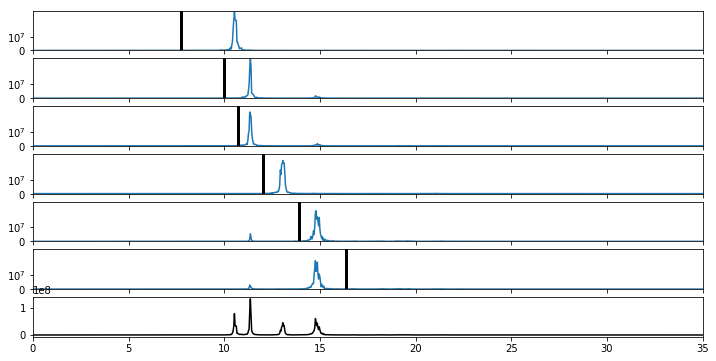

q 6
[ 7.71727407  9.99681142 10.70117137 12.01776273 13.88556023 16.33989088]


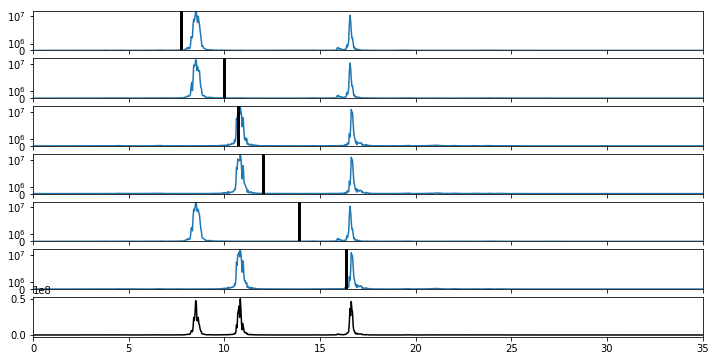

q 7
[ 7.80020015  7.80020015 10.6408771  10.6408771  15.11425487 17.36811989]


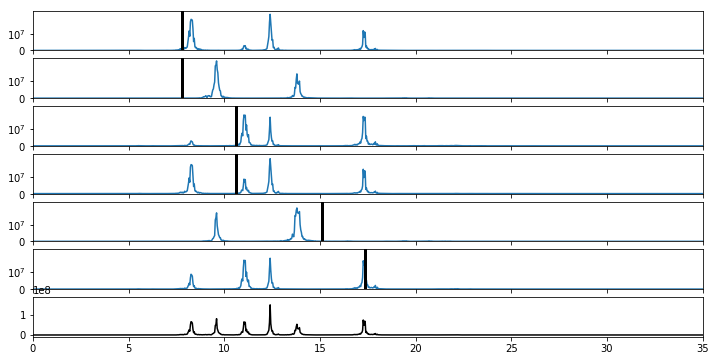

In [10]:
dblue = '#1f77b4'

mapping = ha.irreducible_q_points_mapping
omegas = ha.omegas

n_unique = len(np.unique(mapping))

for ii in np.unique(mapping):
    fig, axs = plt.subplots(nrows=seq.shape[1]+1, sharex=True, figsize=(12, 6))
    
    print(f'q {ii}')
    print(omegas[ii] * omega_to_THz)
    
    spec = abs(seq[mapping == ii])
    for b in range(seq.shape[1]):
        s = spec.sum(axis=(0))
        axs[b].plot(xs, s[b], color=dblue)
        axs[b].set_yscale('symlog', linthreshy=s.max() / 5)
        axs[b].set_ylim([0.01, 1.05 * s.max()])
        # plot 'analytic' frequencies
        w = omegas[ii, b] * omega_to_THz
        axs[b].axvline(w, color='k', linewidth=3)
        
    axs[-1].plot(xs, spec.sum(axis=(0, 1)), color='k')

    plt.xlim([0, 35])
    
    plt.show()